<a href="https://colab.research.google.com/github/patricio-tech/proyectos/blob/master/HHC_Examen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# House Hold Consumption Examen Pregunta 1
Redes neuronales convolucionales

Edwin Solís

2020.09.05

1.	Realizar el pronóstico de la demanda activa para una semana del cliente AMI (household_power_consumption) utilizando una red neuronal convolucional para series de tiempo de varios pasos, previamente se deben preparar los datos de tal forma que la demanda sea en intervalos de cada 15 minutos. 

## RED NEURONAL CONVOLUCIONAL

1. Carga de datos y procesar **[Demanda Activa]**

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras.backend as K

In [ ]:

url = 'https://raw.githubusercontent.com/esoliss/AMI/master/Dataset/household_power_consumption_15min.csv'
df = pd.read_csv(url, error_bad_lines=False)
df = df.drop(df.columns[-1],axis=1)
df = df.rename(columns={"Global_active_power": "P"})
df['datetime'] = df['datetime'].astype('datetime64[ns]')

dfil = df[['datetime','P']].copy()


In [ ]:
dfil = df[['datetime','P']].copy()
ini=df["datetime"][100]#[12315]
fin=df["datetime"][12987]
mask = (dfil["datetime"]>=ini) & (dfil["datetime"]<fin)
seq = dfil.loc[mask] 
dfil = seq

2. Definición de funciones para el modelo

In [ ]:
# definición de métrica para precisión
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# creación del modelo
def crear_modeloFF():
    model = Sequential() 
    #model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Conv1D(filters=26, kernel_size=3, activation='relu', input_shape=(PASOS,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=[soft_acc])
    model.summary()
    return model
# Resultados
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0]=nuevoValor
    return x_test


3. Conversión de serie de tiempo

In [ ]:
PASOS=672
EPOCHS=200
# load dataset
values = dfil['P'].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,PASOS,1)
# split into train and test sets
values = reframed.values
n_train_days = int(dfil.shape[0] - (dfil.shape[0]*0.2+PASOS))
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1],1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(9637, 672, 1) (9637,) (2578, 672, 1) (2578,)


4. Entrenamiento del modelo

In [ ]:

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

results=model.predict(x_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 670, 26)           104       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 335, 26)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8710)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                435550    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 435,705
Trainable params: 435,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 3s 217ms/step - loss: 0.4423 - soft_acc: 0.5513 - val_loss: 0

5. Comparativa y validación de datos

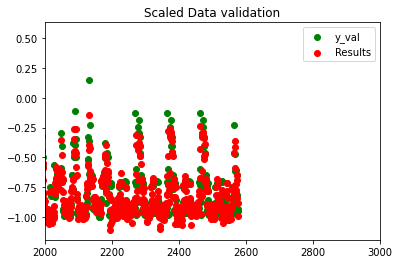

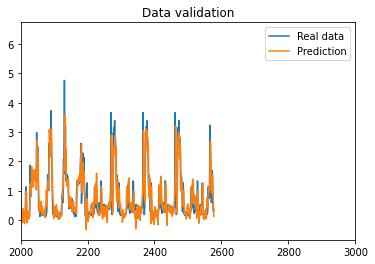

In [ ]:
plt.scatter(range(len(y_val)),y_val,c='g',label='y_val')
plt.scatter(range(len(results)),results,c='r',label='Results')
plt.title('Scaled Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

acc      = history.history[     'soft_acc' ]
val_acc  = history.history[ 'val_soft_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']

compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

6. Métricas del modelo

<Figure size 432x288 with 0 Axes>

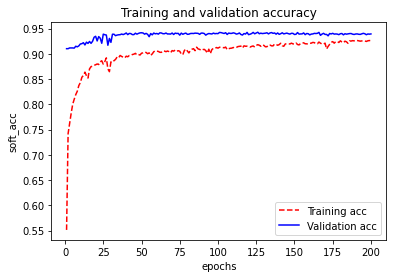

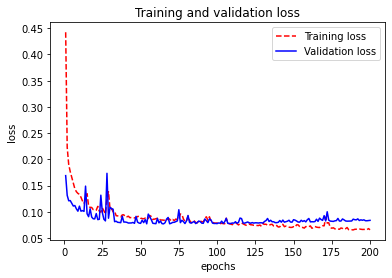

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('soft_acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

7. Predicción de una semana completo **[Mayo]**

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [ ]:
import time
import datetime
# SELECIONAR FECHAS
dfil = df[['datetime','P']].copy()
ini=df["datetime"][12315]
fin=df["datetime"][12987]
mask = (dfil["datetime"]>=ini) & (dfil["datetime"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[672]], axis=1, inplace=True)
values = reframed.values
x_test = values[671:, :]
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
print(x_test.shape)

(1, 672, 1)


In [ ]:
results=[]
for i in range(672):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    #print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

# SELECIONAR FECHAS

dfil = df[['datetime','P']].copy()

ini=df["datetime"][12987]
fin=df["datetime"][13659]
mask = (dfil["datetime"]>=ini) & (dfil["datetime"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
y_val = scaler.fit_transform(values)
compara = pd.DataFrame(np.array([y_val[:,0], [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']


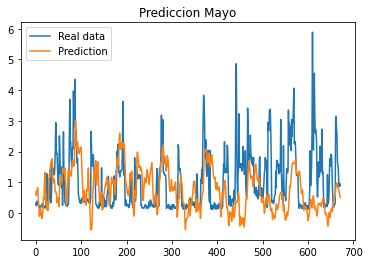

In [ ]:
compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Prediccion Mayo')
plt.legend()
plt.show()